In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split as tts
import scipy

In [ ]:
!git clone https://github.com/Where-Is-The-Exit/271B-project

Cloning into 'metabolite-GCNN'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
cd metabolite-GCNN

[Errno 2] No such file or directory: 'metabolite-GCNN'
/content/metabolite-GCNN


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tensorflow-gpu==1.15.0
from keras.optimizers import SGD
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dropout, Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
import sys
import graph
import coarsening 
import models
import utils

In [ ]:
import sklearn.covariance

In [ ]:
#MTBLS90_data = pd.read_excel('MTBLS90.xlsx')
#MTBLS90_data = MTBLS90_data.dropna(axis=1)
#height,width = MTBLS90_data.shape
#X = MTBLS90_data.iloc[:,1:width].transpose()
#MTBLS90_Labels = pd.read_excel('MTBLS90_Labels.xlsx')
#y = MTBLS90_Labels.replace("Female Gender",0)
#y = y.replace("Male Gender",1)
#y = y.iloc[:,1]

In [ ]:
_1_7 = pd.ExcelFile('beng212_1_7 (1) (1).xlsx')
#population_dist = pd.read_excel(_1_7,sheet_name = 'population_dist',header = 0)
metabolome_clinical = pd.read_excel(_1_7,sheet_name = 'metabolome_clinical',header = 0)
metabolite_profiles = pd.read_csv("metabolite_profiles.csv")
metabolite_profiles=metabolite_profiles.rename(columns={'Unnamed: 0':'Metabolites'})


In [ ]:
X = metabolite_profiles.transpose()
X = X.rename(columns=X.iloc[0])
X = X.loc[~(X==0).all(axis=1)]
X = X.drop(X.index[0])
X = X.sort_index(axis = 0)
X = X.drop(X.index[-1])

y = metabolome_clinical.sort_index()['Group']
y = y.replace('Stage_III_IV','Cancer')
y = y.replace('Stage_I_II','Cancer')
y = y.replace('Stage_0','Cancer')
y = y.replace('MP','Healthy')
y = y.replace('HS','Healthy')
y = y.replace('Healthy', 0)
y = y.replace('Cancer', 1)

In [ ]:
#print((X - X.mean())/X.std())
X = (X - X.mean())/X.std()


In [ ]:
#y = metabolome_clinical.sort_index()['Group']
#y = y.replace('Stage_III_IV',4)
#y = y.replace('Stage_I_II',3)
#y = y.replace('Stage_0',2)
#y = y.replace('MP',1)
#y = y.replace('HS','Healthy')
#y = y.replace('Healthy',0)


In [ ]:
X = X.astype("float64")
Cor = X.corr(method='spearman')
Cor[abs(Cor)>.6]=1
Cor[abs(Cor)<.6]=0
#drop_indices = C[(C == 0).sum(axis=1)>=(len(C.columns)-1)].index
#Cor = Cor[~((Cor == 0).sum(axis=1)>=(len(Cor.columns)-1))].transpose()
#Cor = Cor[~((Cor == 0).sum(axis=1)>=(len(Cor.columns)-1))].transpose()
#Cor.index
#X = X[Cor.index]

In [ ]:
#drop_indices = C[(C == 0).sum(axis=1)>=(len(C.columns)-1)].index
Cor = Cor[~((Cor == 0).sum(axis=1)>=(len(Cor.columns)-1))].transpose()
Cor = Cor[~((Cor == 0).sum(axis=1)>=(len(Cor.columns)-1))].transpose()
Cor.shape

(131, 131)

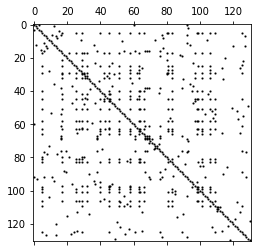

In [ ]:
plt.spy(Cor, markersize=1, color = 'black')

In [ ]:
from sklearn.covariance import graphical_lasso
corr = X.corr(method='spearman')
corr = corr.to_numpy()
test_graph = graphical_lasso(corr,alpha=.6, verbose=True)
#Graph.fit(X_norm)

[graphical_lasso] Iteration   0, cost  2.10e+03, dual gap 7.898e+00
[graphical_lasso] Iteration   1, cost  2.10e+03, dual gap -4.619e-03
[graphical_lasso] Iteration   2, cost  2.10e+03, dual gap -1.167e-04
[graphical_lasso] Iteration   3, cost  2.10e+03, dual gap 8.425e-06


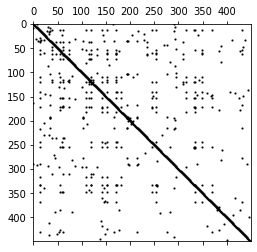

In [ ]:
gm = pd.DataFrame(test_graph[1])
gm[gm!=0]=1
#gm[abs(gm)<.6]=0
plt.spy(gm, markersize=1, color = 'black')

In [ ]:
dif = gm-Cor
dif = dif.to_numpy()
np.linalg.norm(Cor,'fro')

26.019223662515376

In [ ]:
test_graph[1]

array([[ 1., -0., -0., ..., -0.,  0., -0.],
       [-0.,  1.,  0., ..., -0.,  0., -0.],
       [-0.,  0.,  1., ...,  0., -0., -0.],
       ...,
       [-0., -0.,  0., ...,  1., -0., -0.],
       [ 0.,  0., -0., ..., -0.,  1., -0.],
       [-0., -0., -0., ..., -0., -0.,  1.]])

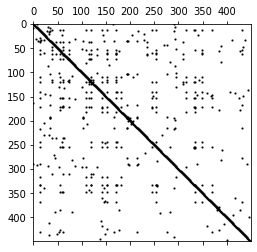

In [ ]:
plt.spy(test_graph[1], markersize=1, color = 'black')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.fit_transform(X)

In [ ]:
Cor.shape

(131, 131)

### Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3, random_state=0)
lr= LR(max_iter = 1000000000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


### CNN

In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 1
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]; print('step2:', n_timesteps, n_features,n_outputs)
    model = Sequential(); print('setup model')
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu',input_shape = (n_timesteps, n_features)));print('L1')
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu')); print('L2')
    model.add(Dropout(0.5)); print('L3')
    model.add(MaxPooling1D(pool_size=1)); print('L4')   
    model.add(Flatten()); print('flatten')
    model.add(Dense(100, activation='relu')); print('dense layer')
    model.add(Dense(n_outputs, activation='softmax')); print('final layer')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['binary_accuracy']); print('compile')
    #train_data = tf.data.Dataset.from_tensor_slices((trainX, trainy)); print('train_data')
    #valid_data = tf.data.Dataset.from_tensor_slices((testX, testy));print('tesr_data')
    #train_data = np.asarray(train_data).astype('float32')
    #valid_data = np.asarray(test_data).astype('float32')
    print('tryna fit')
    model.fit(trainX,trainy, epochs=epochs, batch_size=batch_size, verbose=verbose);  print('fit');
    a, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0);
    #return accuracy
    return a,accuracy

In [ ]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.5)
X_test = np.expand_dims(X_test,axis = 0)
y_test = np.expand_dims(y_test, axis = 0)
X_train = np.expand_dims(X_train,axis = 0)
y_train = np.expand_dims(y_train, axis = 0)
X_train = np.asarray(X_train ).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test ).astype('float32')
y_test = np.asarray(y_test).astype('float32')
evaluate_model(X_train, y_train, X_test, y_test)

step2: 203 450 203
setup model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
L1
L2
L3

L4
flatten
dense layer
final layer
compile
tryna fit

fit


(10393.1279296875, 0.5566502213478088)

This pord

### GCN

In [ ]:
#from scipy.stats import pearsonr
##from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
#def calculate_pvalues(df):
#    df = df.dropna()._get_numeric_data()
#    dfcols = pd.DataFrame(columns=df.columns)
#    pvalues = dfcols.transpose().join(dfcols, how='outer')
#    for r in df.columns:
#        for c in df.columns:
#            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
#    return pvalues

In [ ]:
#PVALUES = calculate_pvalues(O)

In [ ]:
#X = X.astype(float)
#C = X.corr(method='spearman')
#Pval = calculate_pvalues(C)
#Pval[Pval<=.00001]=1
#Pval[(Pval>.00001) & (Pval<1)] = 0
#Pval

Layer 0: M_0 = |V| = 786 nodes (336 added),|E| = 498 edges
Layer 1: M_1 = |V| = 393 nodes (0 added),|E| = 326 edges
284 450
786
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
create empty
start loop
first if
start loop
start loop
first if
start loop
first if
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
first if
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
first if
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
first if
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
start loop
first if
start loop
first if
start loop
first if
start loop
first if
start loop
first if
start loo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


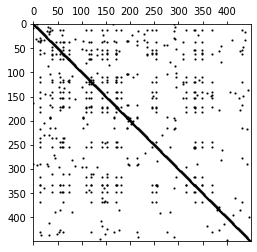

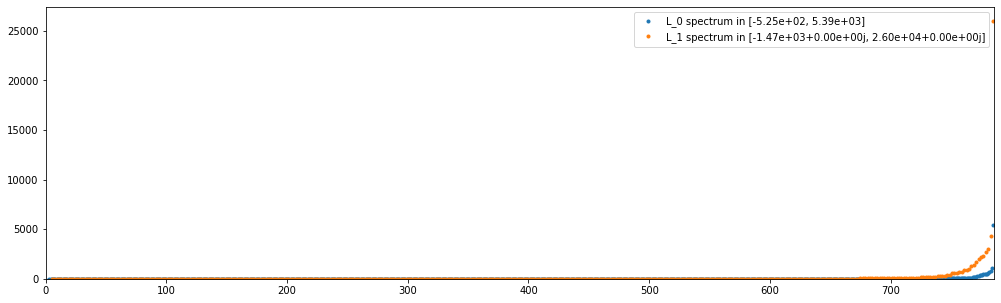

In [ ]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3)
#print(X_train.shape)
X_train = np.asarray(X_train ).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

F = scipy.sparse.csr_matrix(Cor)
plt.spy(F, markersize=1, color = 'black')

graphs, perm = coarsening.coarsen(F, levels=1, self_connections=True) #haven't experimented with levels as much, but 1-2 both yield pretty good results
X_train_c = coarsening.perm_data(X_train, perm)
X_test_c = coarsening.perm_data(X_test, perm)
L = [graph.laplacian(F, normalized=True, renormalized=True) for F in graphs]
graph.plot_spectrum(L)

In [ ]:
len(X_train)

284

In [ ]:
C = 2
common = {}
common['dir_name']       = 'PPI/'
common['num_epochs']     = 100
common['batch_size']     = len(X_train)
common['decay_steps']    = 10 # 30 for Cancer 50 for MTBLS90 but 30 works well too
common['eval_frequency'] = 10 #

model_perf = utils.model_perf()

common['regularization'] = 1e-2 # 1e-1 for Cancer 1e-2 for MTBLS90 (or drop to 1e-3 for more consistency)
common['dropout']        = 1 
common['learning_rate']  = .001 #.001 for Cancer
common['decay_rate']     = 0.95 #.95 for Cancer
common['momentum']       = 0

common['F']              = [1]
common['K']              = [1]
common['p']              = [1]
common['M']              = [128,C] #128 for Cancer

In [ ]:
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
name = 'Run1'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'chebyshev5' #chebyshev5 is important
params['brelu'] = 'b1relu'
model = models.cgcnn(L,**params)#params['F'],params['K'],params['p'],params['M'])
results = model.fit(X_train_c, y_train, X_test_c, y_test)

NN architecture
  input: M_0 = 786
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 786 * 1 / 1 = 786
    weights: F_0 * F_1 * K_1 = 1 * 1 * 1 = 1
    biases: F_1 = 1
  layer 2: fc1
    representation: M_2 = 128
    weights: M_1 * M_2 = 786 * 128 = 100608
    biases: M_2 = 128
  layer 3: logits (softmax)
    representation: M_3 = 2
    weights: M_2 * M_3 = 128 * 2 = 256
    biases: M_3 = 2
Test
step 10 / 100 (epoch 10.00 / 100):
  learning_rate = 1.00e-03, loss_average = 2.77e+00
  validation accuracy: 53.28 (65 / 122), f1 (weighted): 37.04, loss: 8.91e+00
  time: 0s (wall 0s)
step 20 / 100 (epoch 20.00 / 100):
  learning_rate = 9.50e-04, loss_average = 3.34e+00
  validation accuracy: 59.02 (72 / 122), f1 (weighted): 49.64, loss: 7.64e+00
  time: 1s (wall 1s)
step 30 / 100 (epoch 30.00 / 100):
  learning_rate = 9.03e-04, loss_average = 3.20e+00
  validation accuracy: 72.95 (89 / 122), f1 (weighted): 71.57, loss: 6.56e+00
  time: 1s (wall 1s)
step 40 / 100 (epoch 40.00 / 100):
 

In [ ]:
y_score = model.predict(X_test_c)
y_score

INFO:tensorflow:Restoring parameters from /content/metabolite-GCNN/../checkpoints/PPI/Run1/model-500


array([1.78375259e-01, 4.16505225e-02, 5.52952290e-01, 1.41085714e-01,
       2.20866039e-01, 5.01915105e-02, 5.61308086e-01, 4.69239891e-01,
       7.45971054e-02, 8.25029433e-01, 8.34716856e-01, 8.53275537e-01,
       1.26946568e-01, 2.59037495e-01, 8.28848541e-01, 8.59805048e-02,
       5.28517485e-01, 9.16329086e-01, 5.09331763e-01, 1.63900226e-01,
       1.60839017e-02, 6.67023957e-01, 7.28704214e-01, 3.09130341e-01,
       3.43772839e-03, 7.62184381e-01, 1.77429207e-02, 4.59096491e-01,
       7.19716191e-01, 1.40976289e-03, 6.48011088e-01, 1.00368937e-03,
       6.45705283e-01, 8.94700408e-01, 1.16237796e-04, 1.07221073e-03,
       9.94481087e-01, 2.59918332e-01, 2.37421140e-01, 4.98355865e-01,
       6.72231674e-01, 1.78126931e-01, 4.65866357e-01, 3.30088347e-01,
       3.05695534e-01, 9.99999166e-01, 9.29512024e-01, 7.84426093e-01,
       7.67106652e-01, 5.57967663e-01, 4.18694049e-01, 1.02540918e-01,
       9.49636579e-01, 1.08881719e-01, 8.01159143e-01, 4.64913905e-01,
      

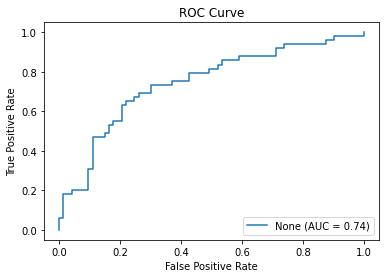

In [ ]:
import sklearn.metrics as m
#y_score = clf.decision_function(ts_x.T)
fpr, tpr, thresholds = m.roc_curve(y_test, y_score)
roc_auc = m.auc(fpr, tpr)
display = m.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.title('ROC Curve')
plt.show()

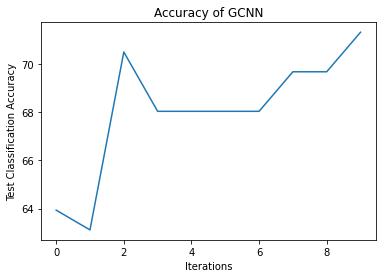

In [ ]:
plt.title("Accuracy of GCNN")
plt.xlabel("Iterations")
plt.ylabel("Test Classification Accuracy")
plt.plot(results[0])


### Dimensionality Reduction and Visualization

In [ ]:
y = metabolome_clinical.sort_index()['Group']
y = y.replace('Stage_III_IV','Cancer')
y = y.replace('Stage_I_II','Cancer')
y = y.replace('Stage_0','Cancer')
y = y.replace('MP','Healthy')
y = y.replace('HS','Healthy')
y = y.replace('Healthy', 0)
y = y.replace('Cancer', 1)

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA, KernelPCA
pca = PCA()
pca.fit(X_train)

print(np.cumsum(pca.explained_variance_ratio_)[1])
components = pca.fit_transform(X)

fig = px.scatter(
    components, x=0, y=1, color=y,
    title="First 2 Principal Components of CRC data",
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

0.17383972


In [ ]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True)
kpca.fit(X_train)
components = kpca.fit_transform(X_train)

fig = px.scatter(
    components, x=0, y=1, color=y_train,
    title="First 3 Principal Components",
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

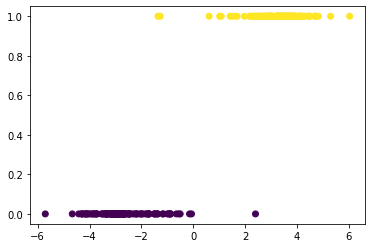

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
LDA_components = LDA.fit_transform(X_train,y_train)

plt.scatter(LDA_components[:,0],y_train, c=y_train)

In [ ]:
LDA.fit(X_train,y_train)
"LDA classification accuracy on test set is: {}".format(LDA.score(X_test,y_test))


'LDA classification accuracy on test set is: 0.7377049180327869'

In [ ]:
LDA.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=20,early_exaggeration = 10.0, init='random',method='exact')
X_tsne = tsne.fit_transform(X_train)

fig = px.scatter(
    X_tsne, x=0, y=1, color=y_train,
    title="First 3 Principal Components",
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

### Common Classification Methods

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA, KernelPCA
pca = PCA()
pca.fit(X)

print(np.cumsum(pca.explained_variance_ratio_)[1])
components = pca.fit_transform(X)

fig = px.scatter(
    components, x=0, y=1, color=y,
    title="First 2 Principal Components of CRC data",
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

0.15931099307103191


In [ ]:
from sklearn.cross_decomposition import PLSRegression
plsda = PLSRegression(n_components=2)
plsda.fit(X,y)
components = plsda.transform(X)
fig = px.scatter(
    components, x=0, y=1, color=y,
    title="Projected CRC Data through PLS",
    labels={'0': 'PLS Component 1', '1': 'PLS Component 2' }
)
fig.show()

In [ ]:
plsda.fit(X_train,y_train)
y_score = plsda.predict(X_test)
fpr, tpr, thresholds = m.roc_curve(y_test, y_score)
roc_auc = m.auc(fpr, tpr)
#display = m.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
#display.plot()
#plt.title('ROC Curve')
y_pred = []
for i in range(len(y_score)):
  if y_score[i] > .5:
    y_pred.append(1)
  else:
    y_pred.append(0)
print("Recall: ", m.recall_score(y_test,y_pred))
tn, fp, fn, tp = m.confusion_matrix(y_test, y_pred).ravel()
print("Specificity", tn/(tn+fp))
print("Precision: ", m.precision_score(y_test,y_pred))
print("Accuracy: ", m.accuracy_score(y_test,y_pred))
print("F1 Score: ", m.f1_score(y_test,y_pred))
print("AUC: ", m.roc_auc_score(y_test,y_score))

Recall:  0.8392857142857143
Specificity 0.8636363636363636
Precision:  0.8392857142857143
Accuracy:  0.8524590163934426
F1 Score:  0.8392857142857143
AUC:  0.9234307359307359


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_score = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
print("Recall: ", m.recall_score(y_test,y_pred))
tn, fp, fn, tp = m.confusion_matrix(y_test, y_pred).ravel()
print("Specificity", tn/(tn+fp))
print("Precision: ", m.precision_score(y_test,y_pred))
print("Accuracy: ", m.accuracy_score(y_test,y_pred))
print("F1 Score: ", m.f1_score(y_test,y_pred))
print("AUC: ", m.roc_auc_score(y_test,y_score))

Recall:  0.9285714285714286
Specificity 0.9696969696969697
Precision:  0.9629629629629629
Accuracy:  0.9508196721311475
F1 Score:  0.9454545454545454
AUC:  0.9875541125541125


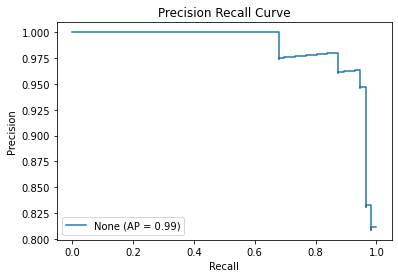

In [ ]:
precision, recall, thresholds = m.precision_recall_curve(y_test, y_score)
pre_rec = m.average_precision_score(y_test, y_score)
display = m.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pre_rec, estimator_name=None)
display.plot()
plt.title('Precision Recall Curve')
plt.show()

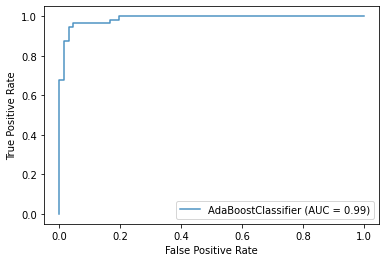

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [ ]:
y_pls = y_train.astype('int')

In [ ]:
b = np.zeros((y_pls.size, y_pls.max()+1))
b[np.arange(y_pls.size),y_pls] = 1

In [ ]:
from sklearn.neural_network import MLPClassifier
acc = 0
#for i in range(10):
mlp = MLPClassifier(hidden_layer_sizes=[150,50,10],learning_rate='adaptive',max_iter=500,n_iter_no_change=20,alpha=.1)
mlp.fit(X_train,y_train)
acc = mlp.score(X_test,y_test)
acc
#  if (acc > .8):
#    break

0.8360655737704918

In [ ]:
import sklearn.metrics as m
y_score = mlp.predict_proba(X_test)[:,1]
y_pred = mlp.predict(X_test)
print("Recall: ", m.recall_score(y_test,y_pred))
tn, fp, fn, tp = m.confusion_matrix(y_test, y_pred).ravel()
print("Specificity", tn/(tn+fp))
print("Precision: ", m.precision_score(y_test,y_pred))
print("Accuracy: ", m.accuracy_score(y_test,y_pred))
print("F1 Score: ", m.f1_score(y_test,y_pred))
print("AUC: ", m.roc_auc_score(y_test,y_score))

Recall:  0.8333333333333334
Specificity 0.8648648648648649
Precision:  0.8
Accuracy:  0.8524590163934426
F1 Score:  0.816326530612245
AUC:  0.90990990990991


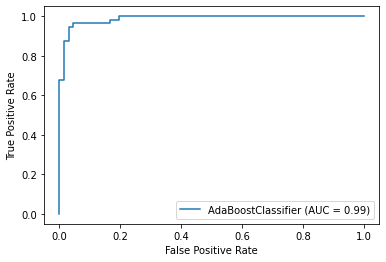

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=1)
plt.show()

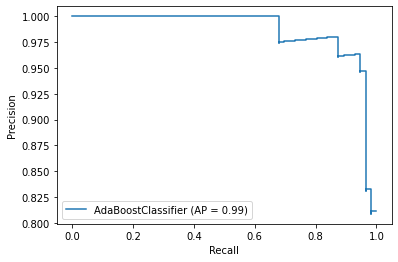

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_precision_recall_curve(clf, X_test,y_test,ax=ax, alpha=1)
plt.show()

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(X_train,y_train)
svc.score(X_test,y_test)

0.8524590163934426

In [ ]:
y_score = svc.decision_function(X_test)
y_pred = svc.predict(X_test)
print("Recall: ", m.recall_score(y_test,y_pred))
tn, fp, fn, tp = m.confusion_matrix(y_test, y_pred).ravel()
print("Specificity", tn/(tn+fp))
print("Precision: ", m.precision_score(y_test,y_pred))
print("Accuracy: ", m.accuracy_score(y_test,y_pred))
print("F1 Score: ", m.f1_score(y_test,y_pred))
print("AUC: ", m.roc_auc_score(y_test,y_score))

Recall:  0.875
Specificity 0.8333333333333334
Precision:  0.8166666666666667
Accuracy:  0.8524590163934426
F1 Score:  0.8448275862068966
AUC:  0.9155844155844156


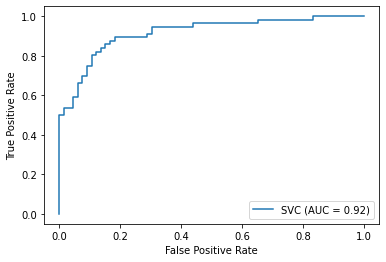

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_roc_curve(svc, X_test, y_test, ax=ax, alpha=1)
plt.show()

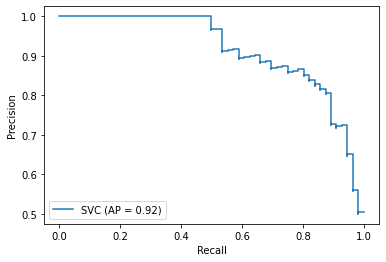

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_precision_recall_curve(svc, X_test, y_test, ax=ax, alpha=1)
plt.show()

In [ ]:
svc_r = SVC(kernel='rbf',C=3)
svc_r.fit(X_train,y_train)
svc_r.score(X_test,y_test)
y_score = svc_r.decision_function(X_test)
y_pred = svc_r.predict(X_test)
print("Recall: ", m.recall_score(y_test,y_pred))
tn, fp, fn, tp = m.confusion_matrix(y_test, y_pred).ravel()
print("Specificity", tn/(tn+fp))
print("Precision: ", m.precision_score(y_test,y_pred))
print("Accuracy: ", m.accuracy_score(y_test,y_pred))
print("F1 Score: ", m.f1_score(y_test,y_pred))
print("AUC: ", m.roc_auc_score(y_test,y_score))

Recall:  0.7321428571428571
Specificity 0.8787878787878788
Precision:  0.8367346938775511
Accuracy:  0.8114754098360656
F1 Score:  0.7809523809523811
AUC:  0.9283008658008658


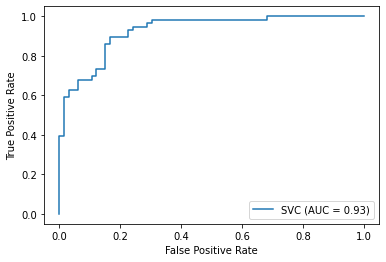

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_roc_curve(svc_r, X_test, y_test, ax=ax)
plt.show()

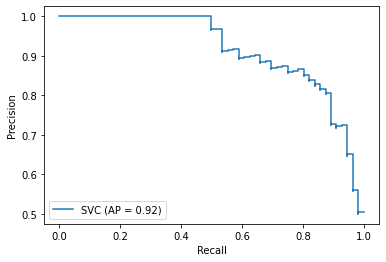

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_precision_recall_curve(svc, X_test, y_test, ax=ax)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=10)
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)

0.9344262295081968

In [ ]:
y_score = rfc.predict_proba(X_test)[:,1]
y_pred = rfc.predict(X_test)
print("Recall: ", m.recall_score(y_test,y_pred))
tn, fp, fn, tp = m.confusion_matrix(y_test, y_pred).ravel()
print("Specificity", tn/(tn+fp))
print("Precision: ", m.precision_score(y_test,y_pred))
print("Accuracy: ", m.accuracy_score(y_test,y_pred))
print("F1 Score: ", m.f1_score(y_test,y_pred))
print("AUC: ", m.roc_auc_score(y_test,y_score))

Recall:  0.9107142857142857
Specificity 0.9545454545454546
Precision:  0.9444444444444444
Accuracy:  0.9344262295081968
F1 Score:  0.9272727272727271
AUC:  0.9672619047619048


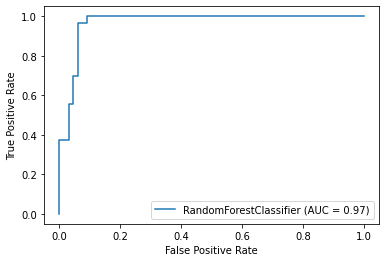

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_roc_curve(rfc, X_test, y_test, ax=ax)
plt.show()

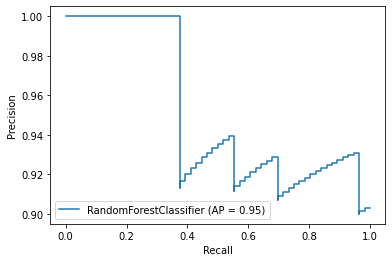

In [ ]:
ax = plt.gca()
rfc_disp = m.plot_precision_recall_curve(rfc, X_test, y_test, ax=ax)
plt.show()

In [ ]:
y_score = model.predict(X_test_c)
y_pred = []
for i in range(len(y_score)):
  if y_score[i] > .5:
    y_pred.append(1)
  else:
    y_pred.append(0)

INFO:tensorflow:Restoring parameters from /content/metabolite-GCNN/../checkpoints/PPI/Run1/model-500


In [ ]:
print("Recall: ", m.recall_score(y_test,y_pred))
tn, fp, fn, tp = m.confusion_matrix(y_test, y_pred).ravel()
print("Specificity", tn/(tn+fp))
print("Precision: ", m.precision_score(y_test,y_pred))
print("Accuracy: ", m.accuracy_score(y_test,y_pred))
print("F1 Score: ", m.f1_score(y_test,y_pred))
print("AUC: ", m.roc_auc_score(y_test,y_score))

Recall:  0.9107142857142857
Specificity 0.9696969696969697
Precision:  0.9622641509433962
Accuracy:  0.9426229508196722
F1 Score:  0.9357798165137615
AUC:  0.9916125541125541


In [ ]:
Y_score = np.zeros(shape=[122,7])
#Y_score[:,0] = clf.decision_function(X_test)
Y_score[:,0] = mlp.predict_proba(X_test)[:,1]
Y_score[:,1] = svc.decision_function(X_test)
Y_score[:,2] = svc_r.decision_function(X_test)
Y_score[:,3] = rfc.predict_proba(X_test)[:,1]
Y_score[:,4] = plsda.predict(X_test)[:,0]
Y_score[:,5] = model.predict(X_test_c)


INFO:tensorflow:Restoring parameters from /content/metabolite-GCNN/../checkpoints/PPI/Run1/model-500


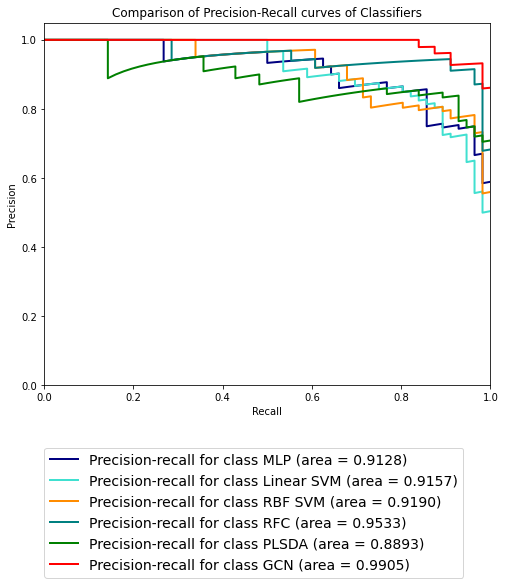

In [ ]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'teal', 'green', 'red'])
plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []


precision = dict()
recall = dict()
average_precision = dict()
list_of_classifiers = [clf, mlp, svc, svc_r, rfc]
for i in range(7):
    precision[i], recall[i], _ = m.precision_recall_curve(y_test,
                                                        Y_score[:, i])
    average_precision[i] = m.average_precision_score(y_test, Y_score[:, i])

list_of_classifiers = ["MLP","Linear SVM","RBF SVM", "RFC", "PLSDA","GCN"]
for i, color in zip(range(6), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.4f})'
                  ''.format(list_of_classifiers[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparison of Precision-Recall curves of Classifiers')
plt.legend(lines, labels, loc=(0, -.53), prop=dict(size=14))


plt.show()

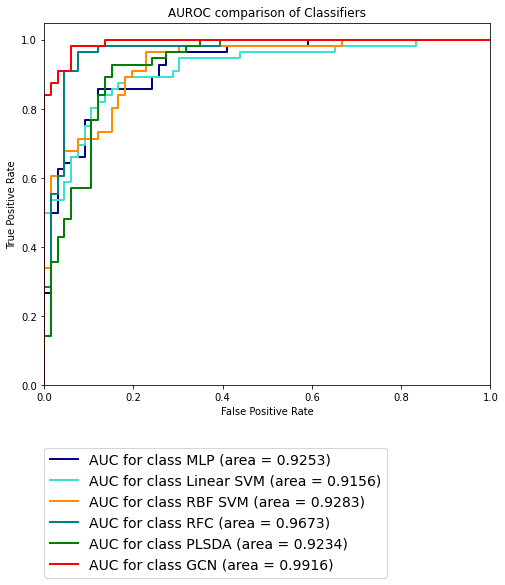

In [ ]:
colors = cycle(['navy', 'turquoise', 'darkorange', 'teal', 'green', 'red'])
plt.figure(figsize=(8, 8))
lines = []
labels = []


fpr = dict()
tpr = dict()
auc = dict()
list_of_classifiers = [clf, mlp, svc, svc_r, rfc]
for i in range(6):
    fpr[i], tpr[i], _ = m.roc_curve(y_test, Y_score[:, i])
    auc[i] = m.roc_auc_score(y_test, Y_score[:, i])

list_of_classifiers = ["MLP","Linear SVM","RBF SVM", "RFC", "PLSDA","GCN"]
for i, color in zip(range(6), colors):
    l, = plt.plot(fpr[i], tpr[i], color=color, lw=2)
    lines.append(l)
    labels.append('AUC for class {0} (area = {1:0.4f})'
                  ''.format(list_of_classifiers[i], auc[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC comparison of Classifiers')
plt.legend(lines, labels, loc=(0, -.53), prop=dict(size=14))


plt.show()